In [8]:
import csv
import math
import gzip
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

import gzip
import pickle
import decimal

In [9]:
lineNames = ["SC05","A900","A975","A976", "PO88"]

scaffNames = ["scaffold_6540","scaffold_6500","scaffold_6680","scaffold_6496",
              "scaffold_6473","scaffold_6328","scaffold_6308","scaffold_6359"]

scaffSizes = [34148556,32352404,24764193,26866924,
              16943266,4453435,3356042,4525533]

bedFile = "/home/miguel/Desktop/HonoursProject/Data/forMiguel/gimble.mainScaffs.bed"
genotypesFile = '/home/miguel/Desktop/HonoursProject/Data/forMiguel/inbredGenotypes.txt'
dataSaveFile = "/home/miguel/Desktop/HonoursProject/Data/forMiguel/scaffGenotypeDict"

In [10]:
scaffIndexDict={a:b for (a,b) in  list(zip(scaffNames,range(len(scaffNames))))}
strainIndexDict={a:b for (a,b) in  list(zip(lineNames,range(len(lineNames))))}
#
def check_genotypes(gl):
    ggl = [x.strip().split("/" or "|") for x in gl]
    ggl = [ 1 if (('.' in x) or (len(x)<2)) else (1 if x[0]==x[1] else 2) for x in ggl ]
    return(ggl)
def count_sites(arr): #this is an array of positions for a particular strain
    (unique,counts) = np.unique(arr,return_counts=True)
    zeros = 0
    ones = 0
    twos = 0
    for xl in list(zip(unique,counts)):
        if xl[0] == 0:
            zeros = xl[1]
        if xl[0] == 1:
            ones = xl[1]
        if xl[0] == 2:
            twos = xl[1]
    return([zeros,ones,twos])

def calc_diversity(winArr): # a window of sites, each has the genotypes
    countsByStrain = [count_sites(x) for x in winArr.transpose()] #transpose to get strain-wise site list
    divByStrain = [0 if (x[1]+x[2])==0 else 1.0/2*x[2]/(x[1]+x[2]) for x in countsByStrain]
    return(divByStrain)
#
with gzip.open(dataSaveFile,mode="rb") as infile:
    scaffGenotypeDict = pickle.load(infile)
#
def arraytostring(_):
    str1 = ''
    for element in _:
        str1 += element
    return str1

In [11]:
threshold = 0.001
tract_number = []
for testchr in scaffGenotypeDict:
    chunkSize = 30000
    windowWidth = 5 #as a number of chunks per window
        #print("window size \t")
        #(chunkSize*windowWidth)
    
    stride = 1  #should probably keep as 1

    numChunks = int(len(scaffGenotypeDict[testchr])/chunkSize)
        #print("\n number of chunks in chromosome")
        #print(numChunks)
    chunks = np.array_split(scaffGenotypeDict[testchr],numChunks);

    chunkSizeTrue = len(chunks[1])
        #print("\n true chunk size after  array split")
        #print(chunkSizeTrue)

        #print("\n true window size")
        #print(chunkSizeTrue*windowWidth)

    divCalc = [calc_diversity(x) for x in chunks]
    divCalc = np.asarray(divCalc)
        #returns list of windows, each window a list of per-strain results. 
        #take the transpose to get each strain as a list of the windows
    allcounts = [[count_sites(y) for y in x.transpose()] for x in chunks]
        # print(allcounts[1])
    coverage = [(chunkSizeTrue-x[0])/chunkSizeTrue for x in [y[0]for y in allcounts]]
    divCalcByStrain = divCalc.transpose()
        #
    windows = [] #windows in terms of left and right [l,r] indices of the underlying chunks
    for x in range(0,numChunks-(windowWidth-stride),stride):
        windows.append([x,x+windowWidth])
    res = [   [[] for x in range(numChunks)] for y in range(len(lineNames)) ]
        #each item in res will be for a different strain.  
        # for each strain, we go through the (overlapping) windows. Each window gets an average score from underlying chunks
        # each of the chunks is a list of the average values from the windows that cover it
        # the chunks at the begiining and end will have fewer scores (fewer overlapping windows)
    for strainIdx in range(len(lineNames)):    
        for [l,r] in windows: 
            #calc average diversity in this window as mean diversity in underlying chunks
            thisWinDiv = divCalcByStrain[strainIdx][l:r]
            total = sum(thisWinDiv)
            mean = total/len(thisWinDiv)
                #for each chunk in this window, append the corresponding score.We drop the last few windows 
            for x in range(l,r,1):
                res[strainIdx][x].append(mean)
    overlapingDivCalcByStrain = [[ max(x) for x in thisRes] for thisRes in res]
         #i.e. we will give any chunk the highest score from the windows which contain it
         # this makes sense for spanning data
         # we could also take the average or any other function.
    overlapingDivCalcByStrain = np.asanyarray(overlapingDivCalcByStrain)
    for index,thisStrainIdx in enumerate(lineNames):
        overlapingDivCalcByStrain = [[ max(x) for x in thisRes] for thisRes in res]
        hetero_or_not = []
        for chunk in overlapingDivCalcByStrain[index]:
                if chunk >= threshold:
                    hetero_or_not.append(1)
                else:
                    hetero_or_not.append(0)
        hetero_or_not = str(hetero_or_not)
        hetero_or_not = arraytostring(hetero_or_not)
        hetero_or_not = hetero_or_not.replace(',','')
        hetero_or_not = hetero_or_not.replace(' ','')
        listOnes = hetero_or_not.split('0')
        hetero_or_not = [len(y) for y in listOnes if y !='']
        hetero_or_not = hetero_or_not[1:-1]
        tract_number.append(len(hetero_or_not))
print('The number of tracts for a threshold of '+str(threshold)+' is '+str(sum(tract_number)) )

The number of tracts for a threshold of 0.001 is 72


In [13]:
#plotting tracts at given thresholds
tracts_per_threshold =[]
#thresholds = np.arange(0.0003, 0.004, 0.00005)
thresholds = [0.0015, 0.002]
for threshold in thresholds:
    tract_number = []
    for testchr in scaffGenotypeDict:
        chunkSize = 50000
        windowWidth = 3 #as a number of chunks per window
        #print("window size \t")
        #(chunkSize*windowWidth)
    
        stride = 1  #should probably keep as 1

        numChunks = int(len(scaffGenotypeDict[testchr])/chunkSize)
        #print("\n number of chunks in chromosome")
        #print(numChunks)
        chunks = np.array_split(scaffGenotypeDict[testchr],numChunks);

        chunkSizeTrue = len(chunks[1])
        #print("\n true chunk size after  array split")
        #print(chunkSizeTrue)

        #print("\n true window size")
        #print(chunkSizeTrue*windowWidth)

        divCalc = [calc_diversity(x) for x in chunks]
        divCalc = np.asarray(divCalc)
        #returns list of windows, each window a list of per-strain results. 
        #take the transpose to get each strain as a list of the windows
        allcounts = [[count_sites(y) for y in x.transpose()] for x in chunks]
        # print(allcounts[1])
        coverage = [(chunkSizeTrue-x[0])/chunkSizeTrue for x in [y[0]for y in allcounts]]
        divCalcByStrain = divCalc.transpose()
        #
        windows = [] #windows in terms of left and right [l,r] indices of the underlying chunks
        for x in range(0,numChunks-(windowWidth-stride),stride):
            windows.append([x,x+windowWidth])
        res = [   [[] for x in range(numChunks)] for y in range(len(lineNames)) ]
        #each item in res will be for a different strain.  
        # for each strain, we go through the (overlapping) windows. Each window gets an average score from underlying chunks
        # each of the chunks is a list of the average values from the windows that cover it
        # the chunks at the begiining and end will have fewer scores (fewer overlapping windows)
        for strainIdx in range(len(lineNames)):    
            for [l,r] in windows: 
            #calc average diversity in this window as mean diversity in underlying chunks
                thisWinDiv = divCalcByStrain[strainIdx][l:r]
                total = sum(thisWinDiv)
                mean = total/len(thisWinDiv)
                #for each chunk in this window, append the corresponding score.We drop the last few windows 
                for x in range(l,r,1):
                    res[strainIdx][x].append(mean)
        overlapingDivCalcByStrain = [[ max(x) for x in thisRes] for thisRes in res]
         #i.e. we will give any chunk the highest score from the windows which contain it
         # this makes sense for spanning data
         # we could also take the average or any other function.
        overlapingDivCalcByStrain = np.asanyarray(overlapingDivCalcByStrain)
        for index,thisStrainIdx in enumerate(lineNames):
            overlapingDivCalcByStrain = [[ max(x) for x in thisRes] for thisRes in res]
            hetero_or_not = []
            for chunk in overlapingDivCalcByStrain[index]:
                    if chunk >= threshold:
                        hetero_or_not.append(1)
                    else:
                        hetero_or_not.append(0)
            hetero_or_not = str(hetero_or_not)
            hetero_or_not = arraytostring(hetero_or_not)
            hetero_or_not = hetero_or_not.replace(',','')
            hetero_or_not = hetero_or_not.replace(' ','')
            listOnes = hetero_or_not.split('0')
            hetero_or_not = [len(y) for y in listOnes if y !='']
            hetero_or_not = hetero_or_not[1:-1]
            tract_number.append(len(hetero_or_not))
    tracts_per_threshold.append(sum(tract_number))
    

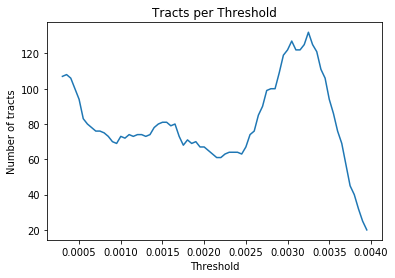

In [7]:
x = np.arange(0.0003, 0.004, 0.00005)
y = tracts_per_threshold
plt.plot(x,y)
plt.xlabel("Threshold")
plt.ylabel("Number of tracts")
plt.title('Tracts per Threshold')
plt.savefig(r'/home/miguel/Desktop/HonoursProject/Tracts_per_threshold.png')

In [14]:
tracts_per_threshold

[81, 67]